# CSE 252A Computer Vision I Fall 2017
## Assigment 2

---
This assignment contains theoretical and programming exercises. If you plan to submit hand written answers for theoretical exercises, please be sure your writing is readable and merge those in order with the final pdf you create out of this notebook. 

## Problem 1: Irradiance [4 pts]
Consider a rectangular surface with vertices (-3,-2,1); (3,-2,1); (-3,2,1) and (3,2,1). 
The radiance on the surface is given by $L.(x^2+y^2+3)$ where L is a constant.

What is the irradiance arriving at the position (0,0,0) with the normal vector (0,0,1)?
<img src = "fig1_2.png">

## Problem 2: Irradiance [4 pts]
Consider a cylinder with radius r and height h whose base is centered at z=0 along the xy-plane.
The walls of the cylinder have a constant radiance L and the top of the cylinder has constant radiance 2L.

What is the irradiance E at the point (0,0,0) assuming that the surface at (0,0,0) has a normal vector of (0,0,1)? 

## Problem 3: Diffused Objects and Shading Fields [4 pts]
We see a diffuse sphere centered at the origin, with radius one and albedo $\rho$, in an orthographic camera, looking down the z-axis.

This sphere is illuminated by a distant point light source whose direction is (0,0,1). There is no other illumination. 

Show that the shading field in the camera is $\rho\sqrt{1-x^2-y^2}$.

## Problem 4: Occlusion, Umbra and Penumbra [2 pts]
We have a square area source and a square occluder, both paraller to a plane. 

The edge length of the source is half that of the occluder, and they are vertically above one another with their centers aligned.

1). What is the shape of the umbra?

2). What is the shape of the outside boundary of the penumbra?

## Problem 5: Photometric Stereo, Specularity Removal, Light Direction [20 pts]

The  goal  of  this  part  of  the  assignment  is  to  implement  a  couple  of  different  algorithms  that  re-
construct a surface using the concept of photometric stereo.  

Additionally, you will implement the specular removal technique of Mallick et al., which enables photometric stereo reconstruction of certain non-Lambertian materials. 

You can assume a Lambertian reflectance function once specularties are removed, but the albedo is unknown and non-constant in the images.  

Your program will take in multiple images as input along with the light source direction (and color when necessary) for each image.

Lastly, you will have to implement a code to calculate the light direction on images of specular objects.

### Part 1: [6 pts]
Implement the photometric stereo technique described in Forsyth and Ponce 5.4 and the lecture notes. 

Your program should have two parts:

a)  Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

b)  Reconstruct the depth map from the normals. You can first try the naive scanline-based shape by integration method described in the book.  If this does not work well on real images, you can use the implementation of the Horn integration technique given below in horn_integrate function.

Try using only im1, im2 and im4 first. Display your outputs as mentioned below.

Then use all four images. (Most accurate).

For each of the above cases you must output:

1). The estimated albedo map

2). The estimated surface normals by either showing
    a). Needle map OR
    b). Three images showing components of surface normal
    
3). A wireframe of depth map

Note: You will find all the data for this part in synthetic_data.pickle

['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3']


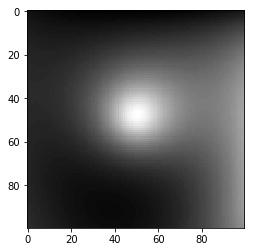

In [1]:
## Example: How to read and access data from a pickle
%matplotlib inline
import pickle
import matplotlib.pyplot as plt

pickle_in = open("synthetic_data.pickle")
data = pickle.load(pickle_in)

#data is a dict which stores each element as a key-value pair. 
print data.keys()

#To access the value of an entity, refer it by its key.
plt.imshow(data['im4'],cmap = 'gray')
plt.show()

In [2]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

def horn_integrate(gx,gy,mask,niter):
    '''
    integrate_horn recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    '''    
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx,mask)
    gy = np.multiply(gy,mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A+B+C+D
    
    den = np.multiply(convolve(mask,d_mask,mode='same'),mask)
    den[den==0] = 1
    rden = 1.0/den
    mask2 = np.multiply(rden,mask)
    
    m_a = convolve(mask,A,mode='same')
    m_b = convolve(mask,B,mode='same')
    m_c = convolve(mask,C,mode='same')
    m_d = convolve(mask,D,mode='same')
    
    term_right = np.multiply(m_c,gx) + np.multiply(m_d,gy)
    t_a = -1.0*convolve(gx,B,mode='same')
    t_b = -1.0*convolve(gy,A,mode='same')
    term_right = term_right+t_a+t_b
    term_right = np.multiply(mask2,term_right)
    
    for k in range(niter):
        g = np.multiply(mask2,convolve(g,d_mask,mode='same'))\
            +term_right;
    
    return g

In [87]:
def photometric_stereo(images,lights, doHornIntegration = True):
    s = images[0].shape
    normals = np.zeros([s[0],s[1],3])
    albedo = np.zeros(s)
    p = np.zeros(s)
    q = np.zeros(s)
    H = np.zeros(s)
    V = []
    V = np.array(lights)   
    for i in range(s[0]):
        for j in range(s[1]):
            I = []
            for image in images:
                I.append(image[i,j])
            if len(I) == 3:    
                g = np.linalg.solve(V, np.array(I)) 
            else:
                g = np.linalg.pinv(V).dot(np.array(I))
            albedo[i,j] = np.linalg.norm(g)
            normals[i,j] = g/np.linalg.norm(g)
            p[i,j] = g[0]/g[2]
            q[i,j] = g[1]/g[2]
    
    #Integration
    for i in range(1,s[0]):        
        H[i,0] = H[i-1,0] + q[i,0]
        
    for i in range(0,s[0]):
        for j in range(1,s[1]):        
            H[i,j] = H[i,j-1] + p[i,j]    
         
    if doHornIntegration:
        H_horn = horn_integrate(p,q,np.ones(s),100000)   
    else:
        H_horn = np.zeros(s)
    return albedo,normals,H,H_horn

In [15]:
#--------------------------------------------------------------------------
#Following code is just a working example so you don't get stuck with any 
#of the graphs required. You may want to write your own code to align the
#results in a better layout
#--------------------------------------------------------------------------
def plotPhotometricStereo(albedo, normals, depth, horn):
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo/albedo_max
    plt.imshow(albedo, cmap='gray')
    plt.show()

    #showing normals as three seperate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    #showing normals as quiver
    X, Y, Z = np.meshgrid(np.arange(0,np.shape(normals)[0], 15), np.arange(0,np.shape(normals)[1], 15),  np.arange(0,np.shape(normals)[2], 15))
    NX = normals[..., 0][::15,::15]
    NY = normals[..., 1][::15,::15]
    NZ = normals[..., 2][::15,::15]
    fig = plt.figure(figsize=(5,5))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=90, elev=-90)
    plt.quiver(X,Y,Z,NX,NY,NZ, facecolor='r', linewidth=.5)
    plt.show()

    #plotting wireframe depth map
    H = depth[::15,::15]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X[...,0],Y[...,0], H)
    plt.show()

    H = horn[::15,::15]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X[...,0],Y[...,0], H)
    plt.show()

using 3 images


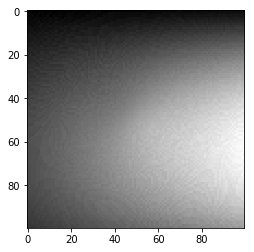

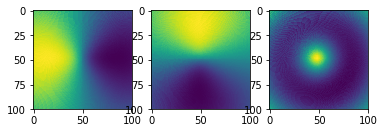

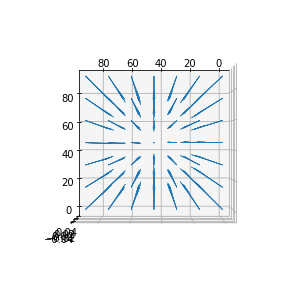

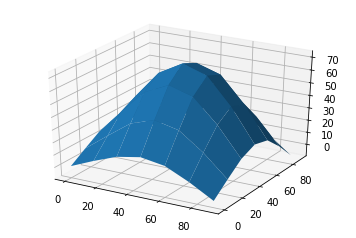

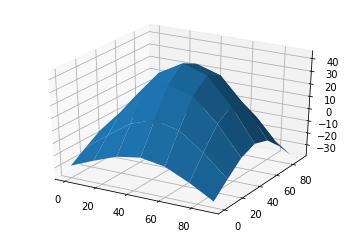

using 4 images


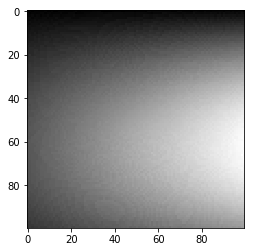

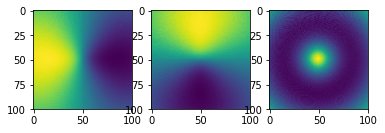

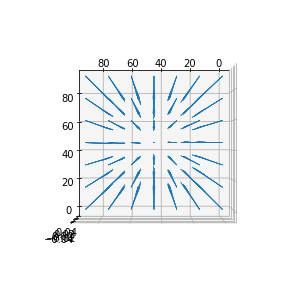

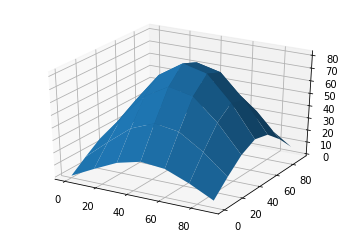

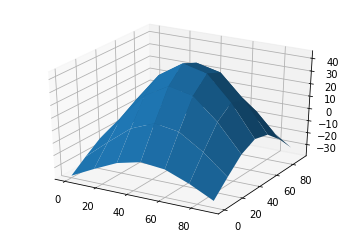

In [91]:
from mpl_toolkits.mplot3d import Axes3D

pickle_in = open("synthetic_data.pickle","rb")
data = pickle.load(pickle_in)

sources = []
for ln in ['l1', 'l2', 'l3', 'l4']:
    light = data[ln]
    sources.append([light[0,1], light[0,0], -1*light[0,2]])

lights = np.vstack((sources[0], sources[1], sources[3]))
#Hint: be careful about the light-source location and direction of light. 
#lights right now stores light-source locations
print "using 3 images"
images = []
images.append(data['im1'])
images.append(data['im2'])
images.append(data['im4'])
albedo, normals, depth, horn = photometric_stereo(images, lights)
plotPhotometricStereo(albedo, normals, depth, horn)

print "using 4 images"
images.append(data['im3'])
lights = np.vstack(((sources[0], sources[1], sources[3], sources[2])))
albedo, normals, depth, horn = photometric_stereo(images, lights)
plotPhotometricStereo(albedo, normals, depth, horn)

### Part 2: [4 pts]
Implement the specularity removal technique described in Beyond Lambert: Reconstructing Specular Surfaces Using Color (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).  

Your program should input an RGB image and light source color and output the corresponding SUV image.  

Try this out first with the specular sphere images and then with the pear images.  
  
For each specular sphere and pear images, include

1). The original image (in RGB colorspace).

2). The recovered S channel of the image.

3). The recovered diffuse part of the image - Use $G = \sqrt{U^2+V^2}$ to represent the diffuse part.

Note: You will find all the data for this part in specular_sphere.pickle and specular_pear.pickle

In [77]:
from matplotlib.pyplot import figure, imshow, axis
def get_rot_mat(rot_v, unit=None):
    '''
    takes a vector and returns the rotation matrix required to align the unit vector(2nd arg) to it
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) #axis of rotation

    rcos = np.dot(rot_v, unit) #cos by dot product
    rsin = np.linalg.norm(uvw) #sin by magnitude of cross product

    #normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # Compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    
    return R

'''
your implementation which takes an RGB image and a vector encoding the orientation of S channel wrt to RGB
'''
def RGBToSUV(I_rgb,rot_vec):
    s = I_rgb.shape
    R = get_rot_mat(rot_vec)
    S = np.zeros((s[0],s[1]))
    G = np.zeros((s[0],s[1]))
    for i in range(s[0]):
        for j in range(s[1]):
            suv = R.dot(I_rgb[i,j])
            S[i,j] = suv[0]
            G[i,j] =  (suv[1]**2 + suv[2]**2)**(0.5)
    return (S,G)

def plotRGBSUV(data, S, G):
    fig = figure()
    
    fig.add_subplot(1,5,1)
    plt.imshow(data['im1'][:,:,0])
    axis('off')
    
    fig.add_subplot(1,5,2)
    plt.imshow(data['im1'][:,:,1])
    axis('off')
    
    fig.add_subplot(1,5,3)
    plt.imshow(data['im1'][:,:,2])
    axis('off')
    
    S_max = S.max()
    S = S/float(S_max)
    fig.add_subplot(1,5,4)
    plt.imshow(S,cmap='gray')
    axis('off')
    
    G_max = G.max()
    G = G/float(S_max)
    fig.add_subplot(1,5,5)
    plt.imshow(G,cmap='gray')
    axis('off')
    
    plt.show()


      r ------ g ------ b ------ S ------ G


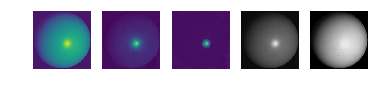

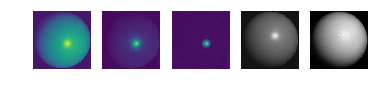

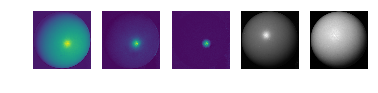

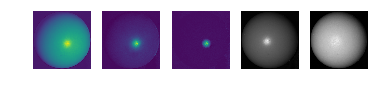

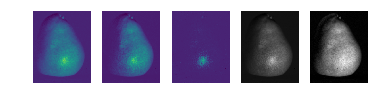

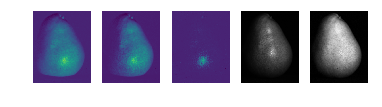

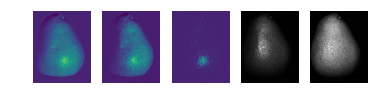

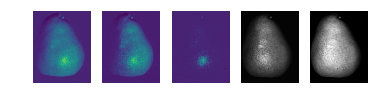

In [82]:
print "      r ------ g ------ b ------ S ------ G"
pickle_in = open("specular_sphere.pickle","rb")
data = pickle.load(pickle_in)
for i in range(1,5):
    #sample input
    S,G = RGBToSUV(data['im'+str(i)],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
    plotRGBSUV(data, S, G)

pickle_in = open("specular_pear.pickle","rb")
data = pickle.load(pickle_in)
#sample input
for i in range(1,5):
    #sample input
    S,G = RGBToSUV(data['im'+str(i)],np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
    plotRGBSUV(data, S, G)

### Part 3: [3 pts]
Combine parts 1 and 2 by running your photometric stereo code on the diffuse components of the specular sphere and pear images. 

For comparison, run your photometric stereo code on the original images (converted to grayscale) as well. You should notice erroneous "bumps" in the resulting reconstructions, as a result of violating the Lambertian assumption.

For each specular sphere and pear image sets, using all the four images, include:

1). The estimated albedo map (original and diffuse)

2). The estimated surface normals (original and diffuse) by either showing
    a). Needle map OR
    b). Three images showing components of surface normal
    
3). A wireframe of depth map (original and diffuse)

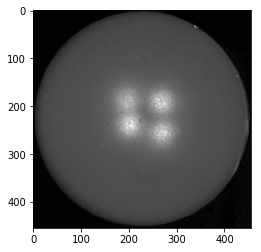

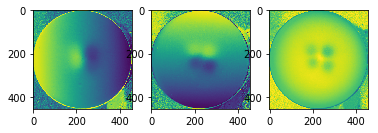

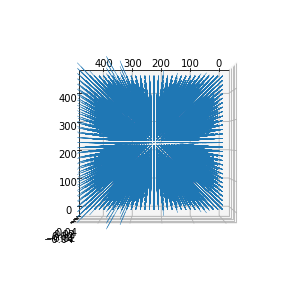

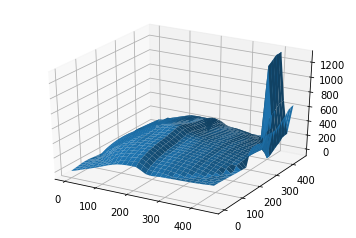

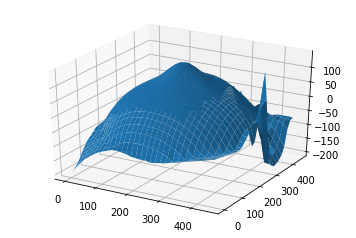

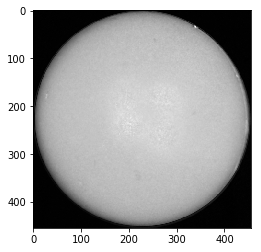

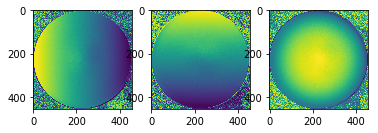

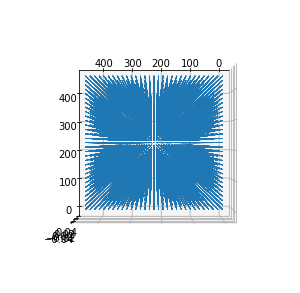

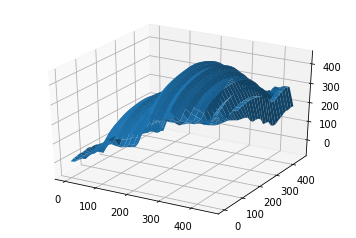

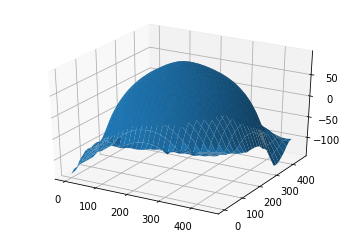

In [96]:
pickle_in = open("specular_sphere.pickle","rb")
data = pickle.load(pickle_in)
lights = np.vstack((data['l1'],data['l2'],data['l3'],data['l4']))
orig_imgs = []
suv_imgs = []
for img in ['im1', 'im2', 'im3', 'im4']:
    image = data[img]
    oimg = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    orig_imgs.append(oimg)
    S,G = RGBToSUV(image,np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
    suv_imgs.append(G)
    
albedo, normals, depth, horn = photometric_stereo(orig_imgs, lights, True)
plotPhotometricStereo(albedo, normals, np.transpose(depth), np.transpose(horn))
albedo, normals, depth, horn = photometric_stereo(suv_imgs, lights, True)
plotPhotometricStereo(albedo, normals, np.transpose(depth), np.transpose(horn))

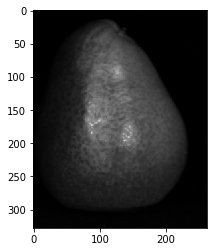

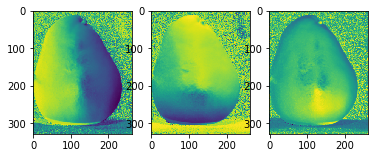

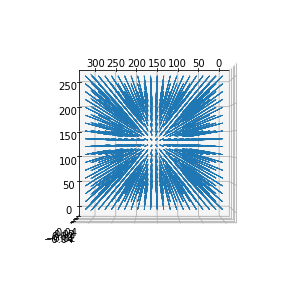

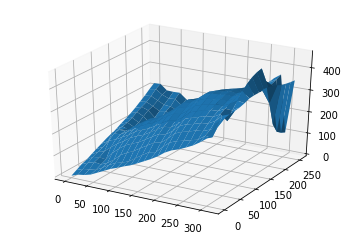

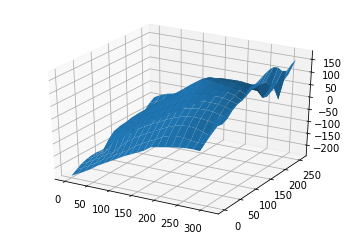

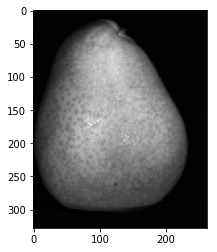

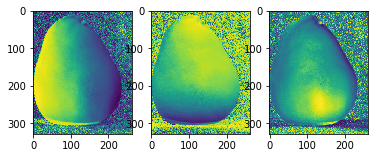

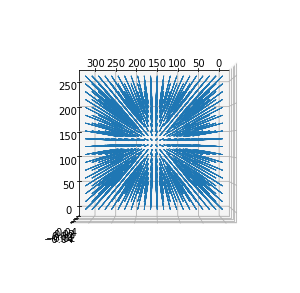

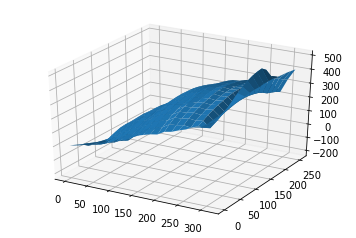

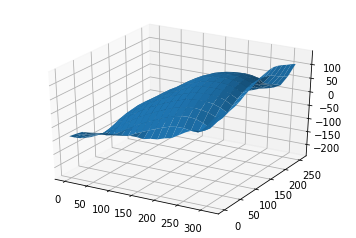

In [95]:
pickle_in = open("specular_pear.pickle","rb")
data = pickle.load(pickle_in)
lights = np.vstack((data['l1'],data['l2'],data['l3'],data['l4']))
orig_imgs = []
suv_imgs = []
for img in ['im1', 'im2', 'im3', 'im4']:
    image = data[img]
    oimg = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    orig_imgs.append(oimg)
    S,G = RGBToSUV(image,np.hstack((data['c'][0][0],data['c'][1][0],data['c'][2][0])))
    suv_imgs.append(G)
    
albedo, normals, depth, horn = photometric_stereo(orig_imgs, lights, True)
plotPhotometricStereo(albedo, normals, np.transpose(depth), np.transpose(horn))
albedo, normals, depth, horn = photometric_stereo(suv_imgs, lights, True)
plotPhotometricStereo(albedo, normals, np.transpose(depth), np.transpose(horn))

##### Part 4: [7 pts]
Often times the light direction is unknown. In these cases it is required to estimate the light direction using a
highly specular ball.  

a). Derive the equations/working-logic to find the light direction L, using the center of the ball, $C = (x,y)^T$, and the brightest point in the image $B = (x,y)^T$. You may find this equation useful: $L = 2N(R.N) - R$ where R is the reflection direction and N is the surface normal. The camera is looking down the z-axis. You may submit a hand-written/typed derivation for this part OR make a seperate markdown cell for it and type it there.

b). Complete the function light_direction(), compute_center(), compute_brightest(), compute_radius() with a code that calculates the light direction in the 8 sphere images in sphere.zip.

c). Using all the images, include a wireframe of depth map

In [ ]:
"""
a) 1.For finding the brightest point we can use numpy to figure out the pixel with maximum intensity.
   2.To calculate the center of the sphere we can traverse the mask image twice.
   In the first traversal we can fing the image row with maximum number of white pixels and in the second traversal 
   we can find the column with maximum white pixels. The corresponding row and column will give the center (cx,cy).
   3. To calculate radius, we need to take the first point (say P) in any row of image which is white. 
       Then using (cx,cy) and P we can get the radius of the sphere.
   4. The 'z' value of the brightest point can be calculated using the radius of sphere.
       (bx - cx)**2 + (by-cy)**2 + (z - 0)**2 = r**2.
   5. Now that we have all the information, we can get normal by subtracting brightest point (B) and center (C)
       of sphere. Reflection vector is (0,0,1).
"""

In [93]:
def compute_radius(x_c, y_c, mask):
    r = 0
    s = mask.shape
    for i in range(s[0]):
        if mask[i,s[1]/2] > 0:
            r += 1
            break
    r = ((x_c - i)**2 + (y_c - s[1]/2)**2)**0.5
    return r

def compute_center(mask):
    x = 0
    y = 0
    s = mask.shape
    x = s[1]/2
    y = s[0]/2
    return x,y

def compute_brightest(img):
    x = 0
    y = 0
    y,x = np.unravel_index(np.argmax(abs(img)), img.shape)
    return x,y

def light_direction(img, mask):
    R = np.array([0, 0, 1])
    cx,cy = compute_center(mask)
    r = compute_radius(cx,cy,mask)
    bx,by = compute_brightest(img)
    N = [0,0,0]
    N[0] = bx - cx
    N[1] = by - cy
    N[2] = (r**2 - N[0]**2 - N[1]**2)**0.5
    N = N/np.linalg.norm(N)
    L = 2*np.dot(N, R)*N - R
    L = L/np.linalg.norm(L)
    x = L[0]
    y = L[1]
    z = L[2]
    return x,y,z

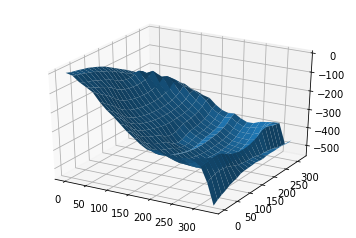

In [97]:
#im1 = imread('./sphere/sphere1.png',flatten=True)
#im2 = imread('./sphere/sphere8.png',flatten=True)
#msk = imread('./sphere/spheremask.png',flatten=True)
#print im1.shape
#plt.imshow(im1)
#plt.show()
#####Do above for all the 8 images#####
#####Code to get the depth map to be written by self#####
#l2 = np.array(light_direction(im2,msk))
#print l2

from scipy.misc import imread
images = []
lights = []
for i in range(1,9):
    im = imread('./sphere/sphere' + str(i) +'.png',flatten=True)
    l = np.array(light_direction(im,msk))
    images.append(im)
    lights.append(l)
albedo, normals, depth, horn = photometric_stereo(images, lights, False)

#showing normals as quiver
X, Y, Z = np.meshgrid(np.arange(0,np.shape(normals)[0], 15), np.arange(0,np.shape(normals)[1], 15),  np.arange(0,np.shape(normals)[2], 15))
ax = fig.gca(projection='3d')
ax.view_init(azim=90, elev=-90)
#plt.quiver(X,Y,Z,NX,NY,NZ, facecolor='r', linewidth=.5)
#plt.show()

#plotting wireframe depth map
H = depth[::15,::15]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X[...,0],Y[...,0], np.transpose(H))
plt.show()